# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №1 - Метод k-средних, предобработка признаков


# <hr\>
**Общая информация**

**Срок сдачи:** до 7 октября 2017, 06:00   
**Штраф за опоздание:** -2 балла после 06:00 7 октября, -4 балла после 06:00 14 октября, -6 баллов после 06:00 21 октября

При отправлении ДЗ указывайте фамилию в названии файла   


Присылать ДЗ необходимо в виде ссылки на свой github репозиторий в slack @alkhamush
Необходимо в slack создать таск в приватный чат:   
/todo Фамилия Имя *ссылка на гитхаб* @alkhamush   
Пример:   
/todo Ксения Стройкова https://github.com/stroykova/spheremailru/stroykova_hw1.ipynb @alkhamush   

Используйте данный Ipython Notebook при оформлении домашнего задания.
<hr\>

# Первое задание - указать фамилию в имени файла

In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn
seaborn.set()
%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Пролог: Модуль sklearn
На наших практических занятиях мы будем использовать [sklearn](http://scikit-learn.org/stable/index.html) (scikit-learn) - наиболее популярный модуль для работы с методами машинного обучения и анализа данных.

Этот модуль регулярно обновляется, расширяется и сопровождается примерами использования тех или иных методов. Помимо самих алгоритмов (например k-средних или линейной регрессии) в нем есть множество вспомогательных функций по работе с данными.

# Туториал: Работа с различными типами признаков

Вспомним какие типы признаков могут встретится при описании объектов исследования и как их представить в доступной для обработки компьтером форме

Типы признаков мы будем рассматривать на примере довольно популярного набора данных [titanic](https://www.kaggle.com/c/titanic/download/train.csv) - информации о выживаемости пассажиров после известной трагедии корабля Titanic.

In [2]:
df_titanic = pd.read_csv('train.csv', sep=',').dropna()
print df_titanic
df_titanic.head()

     PassengerId  Survived  Pclass  \
1              2         1       1   
3              4         1       1   
6              7         0       1   
10            11         1       3   
11            12         1       1   
21            22         1       2   
23            24         1       1   
27            28         0       1   
52            53         1       1   
54            55         0       1   
62            63         0       1   
66            67         1       2   
75            76         0       3   
88            89         1       1   
92            93         0       1   
96            97         0       1   
97            98         1       1   
102          103         0       1   
110          111         0       1   
118          119         0       1   
123          124         1       2   
124          125         0       1   
136          137         1       1   
137          138         0       1   
139          140         0       1   
148         

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
10,11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7000,G6,S
11,12,1,1,"Bonnell, Miss. Elizabeth",female,58.0,0,0,113783,26.5500,C103,S


## Бинарные признаки
Это признаки с двумя возможными значениями
* Пол (мужской, женский)
* Выжил (да, нет)

На вход в алгоритмы обычно подаются в виде значений `{0, 1}` (реже в виде `{-1, 1}`)

In [3]:
# Здесь все нормально
df_titanic.Survived.value_counts()

1    123
0     60
Name: Survived, dtype: int64

In [4]:
# Тут стоит выполнить переобознаение
df_titanic.Sex.value_counts()

male      95
female    88
Name: Sex, dtype: int64

In [5]:
# Например так
df_titanic.Sex = df_titanic.Sex.replace({'male': 0, 'female': 1})
df_titanic.Sex.value_counts()

0    95
1    88
Name: Sex, dtype: int64

## Вещественные признаки

* Возраст
* Сумма, потраченная на билет
* Количество родственников на борту

Как правило остаются в том же виде или выполняется **нормализация** признаков, т.е. переход к одинаковой шкале, например:

* $\tilde{x} = \frac{x - \text{mean}(x)}{\text{std}(x)}$
* $\tilde{x} = \frac{x - \text{min}(x)}{\text{max}(x) - \text{min}(x)}$

## Категориальные признаки

Принимают значения из *неупорядоченного* множества

* Порт погрузки (C = Cherbourg; Q = Queenstown; S = Southampton)
* Точка отправления (St Louis, MO; Montreal, PQ; .. }
* Точка назначения (Chesterville, ON; Roseville, IL; .. }

Обычно такие признаки кодируют с помощью так называемого One Hot Encoding: </br>
для каждой категории создается бинарная маска-столбец, в которой стоит `1` если значение признака равно значению соответствующей категории категории.

Например, для признака "порт погрзки" создается бинарная макска из трех стобцов для каждого из портов: С, Q, S<br/>
Если пассажир заходил на кораблю в порту Southampton, то его признаковое описание будет соответственно: `[0, 0, 1]`

In [6]:
df_titanic.Embarked.head()

1     C
3     S
6     S
10    S
11    S
Name: Embarked, dtype: object

In [7]:
# Сделать в python это можно несколькими способами:

# 1: Через pandas (не очень рекомендуется)
emb = pd.get_dummies(df_titanic.Embarked, prefix='Embarked', prefix_sep='=')
emb.head()

,Embarked=C,Embarked=Q,Embarked=S
1,1,0,0
3,0,0,1
6,0,0,1
10,0,0,1
11,0,0,1


In [8]:
# 2: Функционал sklearn
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse=False)

emb = df_titanic.loc[:, ['Embarked']].replace({'C': 0, 'Q': 1, 'S': 2}).values
emb_enc = encoder.fit_transform(emb)
emb_enc[:5]

array([[ 1.,  0.,  0.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.]])

Про другием способы работы с категориальными переменными можно прочитать вот [тут](https://alexanderdyakonov.wordpress.com/2016/08/03/python-%D0%BA%D0%B0%D1%82%D0%B5%D0%B3%D0%BE%D1%80%D0%B8%D0%B0%D0%BB%D1%8C%D0%BD%D1%8B%D0%B5-%D0%BF%D1%80%D0%B8%D0%B7%D0%BD%D0%B0%D0%BA%D0%B8/)

## Порядковый признаки

Принимают значения из *упорядоченного* множества

* Класс каюты (1 > 2 > 3)

В зависимости от метода остаются можно оставить в исходном виде или применить OneHotEncoding.

## Текстовые признаки - Bag of words

Для демонстрации возьмем текст стихотворения Блока:

Ночь, улица, фонарь, аптека,<br/>
Бессмысленный и тусклый свет.<br/>
Живи еще хоть четверть века -<br/>
Все будет так. Исхода нет.<br/>

Умрешь - начнешь опять сначала<br/>
И повторится все, как встарь:<br/>
Ночь, ледяная рябь канала,<br/>
Аптека, улица, фонарь.<br/>

Пусть каждая строчка - это будет условный документ. Переведем эти документы в числовое представление по методу мешка слов (Bag Of Words)

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

corpus = \
[u'Ночь, улица, фонарь, аптека,',
 u'Бессмысленный и тусклый свет.',
 u'Живи еще хоть четверть века -',
 u'Все будет так. Исхода нет.',
 u'Умрешь - начнешь опять сначала',
 u'И повторится все, как встарь:',
 u'Ночь, ледяная рябь канала,',
 u'Аптека, улица, фонарь.']

In [10]:
vect = CountVectorizer()

bow = vect.fit_transform(corpus)
bow = bow.toarray()
bow.shape

(8, 27)

Получили матрицу размера $8 \times 27$, так как у нас 8 строчек и выделилось 27 униальных слов. Элемент матрицы показывает сколько раз слово встречалось в соответствующем документе.

In [11]:
bow

array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 1, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
        0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 1],
       [0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0,
        0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 1, 0, 0]])

In [12]:
# Посмотрим какие слова стоят по столбцам
for i, w in enumerate(vect.get_feature_names()):
    print u'столбец %d: %s' % (i, w)

столбец 0: аптека
столбец 1: бессмысленный
столбец 2: будет
столбец 3: века
столбец 4: все
столбец 5: встарь
столбец 6: еще
столбец 7: живи
столбец 8: исхода
столбец 9: как
столбец 10: канала
столбец 11: ледяная
столбец 12: начнешь
столбец 13: нет
столбец 14: ночь
столбец 15: опять
столбец 16: повторится
столбец 17: рябь
столбец 18: свет
столбец 19: сначала
столбец 20: так
столбец 21: тусклый
столбец 22: улица
столбец 23: умрешь
столбец 24: фонарь
столбец 25: хоть
столбец 26: четверть


# Туториал: Имплементация собственного метода

Для решения задач вида "имплементируйте метод X" крайне желательно (но необязательно) реализовывать методы с помощью интерфейса sklearn. Ниже вы увидите пример очень простого **классификатора**. Используйте эти наработи для выполнения задания.

Загрузите [датасет](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv) с информацией о характеристиках вина и его качестве. (В метод `pd.read_csv()` можно подать веб-ссылку на данные и пандас их скачает и преобразует в `DataFrame`).

In [13]:
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv', sep=';')

In [14]:
df_wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


Наша задача состоит в предсказании целевого признака `quality` по остальным признакам. `quality` - это вещественная переменная (оценка качества от 0 до 10). Упростим себе задачу - создадим новый столбец `quality_cat` по следующим правилам:

* `quality_cat = 1` если `quality > 5` 
* `quality_cat = 0` - иначе 

Таким образом, `quality_cat` характерует "плохое" и "хорошее" вино.

In [15]:
def prepocess_wine(df):
    df.loc[:, 'quality_cat'] = (df.loc[:, 'quality'] > 5).astype(int)
    df = df.drop('quality', axis=1)
    
    return df

In [16]:
df_wine = df_wine.pipe(prepocess_wine)
df_wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality_cat
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0


Нарисуем распределение хорошего и плохого вина по признаку `alcohol`.

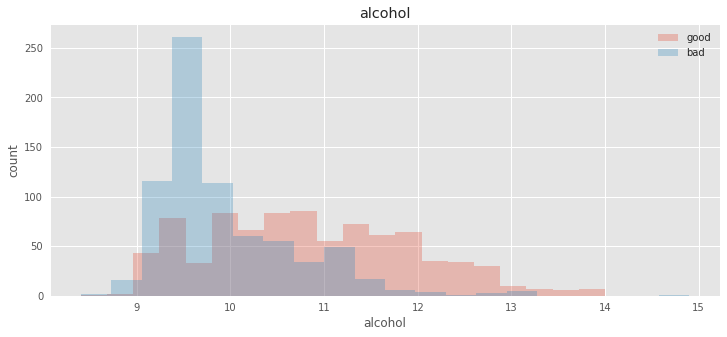

In [17]:
_, ax = plt.subplots(1,1)
df_wine.query('quality_cat == 1').hist('alcohol', alpha=0.3, bins=20, label='good', ax=ax)
df_wine.query('quality_cat == 0').hist('alcohol', alpha=0.3, bins=20, label='bad', ax=ax)
ax.set_xlabel('alcohol')
ax.set_ylabel('count')
plt.legend()

Визуально кажется, что можно найти некоторое пороговое значение признака `alcohol` $\theta$, чтобы хорошо дискриминировать между плохими и хорошим вином:
* Если `alcohol >` $\theta$ - то предсказываем, что вино хорошее
* Если `alcohol <=` $\theta$ - то предсказываем, что вино плохое

Обучаеть классификатор будем очень просто: перебирать значения признака alchol и считать **ошибку** классификации. То значение, где ошибка минимальна и будет оптимальным.

Разделим целевой признак от остальных признаков

In [18]:
X, y = df_wine.iloc[:, :-1].values, df_wine.iloc[:, -1].values

Далее вы увидете пример реализации этого простого классификатора.

In [2]:
from sklearn.base import BaseEstimator, ClassifierMixin

class SimpleClassifier(BaseEstimator, ClassifierMixin): 
    
    def __init__(self):
        """
        Инициализация метода
        """
        
        self.threshold = 0

    def fit(self, X, y=None):
        """
        Выполняет процедуру обучения классификатора. В данном случае - перебор занчения признака alcohol.
        Договоримся, что признак alcohol будет в последнем столбце матрицы X
        """
        
        alcohol = X[:,-1]
        n = float(y.shape[0])
        
        # Задаем пространство поиска
        alco_range = np.arange(alcohol.min(), alcohol.max(), 0.1)
        
        min_error_rate = 1
                
        #  Начинаем поиск
        for theta in alco_range:
            prediction = alcohol > theta
            
            error_rate = sum(prediction != y)/n
            
            if error_rate < min_error_rate:
                min_error_rate = error_rate
                self.threshold = theta  
        
        return self

    def predict(self, X, y=None):
        """
        Процедура предсказания класса по обученному порогу
        """
        
        return (X[:,-1] > self.threshold).astype(int)

Обучаем модель

In [20]:
model = SimpleClassifier()
model.fit(X, y)

print 'Оптимальный порог: %f' % model.threshold

Оптимальный порог: 10.000000


Получаем предсказание модели (на обучающей выборке)

In [21]:
y_hat = model.predict(X)

Оценим долю ошибок на обучающей выборке

In [22]:
error_rate = sum(y_hat != y)/float(y.shape[0])
print 'Доля ошибок на обучающей выборке: %f' % error_rate

Доля ошибок на обучающей выборке: 0.295184


## Проверка метода на контрольной выборке

Мы обучили наш метод на данных о красном виде. 

Посмотрим, выполняется ли так же хорошо закономерность между качеством и уровнем алкоголя в белом вине.

In [23]:
df_wine_test = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv',
                           sep=';')

df_wine_test = df_wine_test.pipe(prepocess_wine)
df_wine_test.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality_cat
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,1
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,1
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,1
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,1
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,1


In [24]:
X_test, y_test = df_wine_test.iloc[:, :-1].values, df_wine_test.iloc[:, -1].values
y_hat = model.predict(X_test)

In [25]:
error_rate = sum(y_hat != y_test)/float(y_test.shape[0])
print 'Доля ошибок на контрольной выборке: %f' % error_rate

Доля ошибок на контрольной выборке: 0.312577


Получилось неплохо и это лишь наивный алгоритм на одном признаке! Ну а выводы делайте сами =)

# Имплементация K-means

Пользуясь наработками выше, имплементируйте метод k-means.  
При инициализации необходимо задавать количество кластеров, функцию расстояния между кластерами (для оригинального k-means - евклидово расстояние) и начальное состояние генератора случайных чисел.

После обучения, среди атрибутов класса `Kmeans` должны появится
* Метки кластеров для объектов
* Координаты центройдов кластеров

k-means - это алгоритм **кластеризации**, а не классификации, а посему метод `.predict()` в нем фактически не нужен, но он может возвращать метки ближайшего кластера для объектов.

###### Задание 1 (2 баллов)
Имплементируйте метод k-means

Теория для выполнения задания 2 и 3 остаётся на самостоятельное изучение. Теории немного и она совсем простая.

###### Задание 2 (2 балла)
Имплементируйте класс MiniBatchKMeans, который является классом наследником Kmeans.

###### Задание 3 (2 балла)
Превратите k-means в k-means++. Для этого нужно реализовать метод в классе Kmeans, который будет инициализировать более "хорошие" значения центроидов. Чтобы использовался метод k-means++, в параметр init необходимо передать строковое значение 'k-means' (по умолчанию 'random').

###### Задание 4 (2 балла)
В пункте "Проверка корректности метода" нужно нарисовать графики, которые показывают зависимость времени выполнения алгоритма от количества сэмплов. Графики должны быть  нарисованы для различных комбинаций реализаций алгоритма (k-means, k-means++, k-means с MiniBatchKMeans, k-means++ с MiniBatchKMeans). Для этого рекомендуется использовать инструмент %timeit. График достаточно построить на 5-10 точках.

###### Задание 5 (2 балла)
В пункте "Применение K-means на реальных данных" нужно сравнить различные реализации k-means (k-means, k-means++, k-means с MiniBatchKMeans, k-means++ с MiniBatchKMeans). После чего написать вывод, в котором должно быть объяснение того, почему один алгоритм оказался лучше остальных или почему не было выявлено лучшего алгоритма.

In [3]:
import math
from sklearn.base import ClusterMixin
import random

class Kmeans(BaseEstimator, ClusterMixin): 
    
    def __init__(self, k=2, metric='euclidean', max_iter=1000,
                 random_state=None, init='random', epsilon=0.00001):
        """
        Инициализация метода
        :k - количество кластеров
        :metric - функция расстояния между объектами
        :max_iter - максиальное количество итераций
        :random_state - seed для инициализации генератора случайных чисел
        """
        
        self.k = k
        self.random_state = random_state
        self.metric = metric
        self.max_iter = max_iter
        self.init = init
        self.dev = sys.float_info.max
        self.epsilon = epsilon
        return None

    def init_centroids(self, X):
        # Инициализируем массив с центроидами кластеров
        if self.init == 'random':
            self.centroids = X[np.random.permutation(xrange(0, X.shape[0]))[:self.k]]
        elif self.init == 'k-means':
            nearest = np.empty(self.k, dtype=np.int64)
            chosen = np.empty(self.k, dtype=np.int64)
            self.centroids = np.empty((self.k, X.shape[1]), dtype=np.float64)
            
            #выбрали начальный центроид
            chosen[0] = np.random.choice(xrange(0, X.shape[0]))
            self.centroids[0] = X[chosen[0]]
            #выбираем оставшиеся self.k - 1 центроиды
            for ind in xrange(1, self.k):
                dist = np.empty(X.shape[0])
                #для каждого элемента считаем расстояние до ближайшего среднего
                dist = ((self.centroids[:ind, np.newaxis, :] - X)**2).sum(2).min(0)
                #выбираем новый центроид пропорционально расстоянию до ближайшего среднего
                cummul_sum = dist.cumsum()
                cummul_sum /= cummul_sum.max()
                new_c = 0
                #выбираем случайную величину, а затем и объект, соответствующий интервалу, в который она попала
                p = random.uniform(0, 1)
                new_c = cummul_sum[cummul_sum > p].argmin()
                # Проверяем, что выбранный, новый центроид не принадлежит множеству уже выбранных
                for j in xrange(0, ind):
                    if chosen[j] == new_c:
                        if new_c == X.shape[0] - 1:
                            new_c -= 1
                        else:
                            new_c += 1
                chosen[ind] = new_c
                self.centroids[ind] = X[new_c]
        
        
    def fit(self, X, y=None):
        """
        Процедура обучения k-means
        """
        
        # Инициализация генератора случайных чисел
        np.random.seed(self.random_state)
        
        # Массив с метками кластеров для каждого объекта из X
        self.labels = np.empty(X.shape[0], dtype=np.int64)
        
        # Инициализируем центроиды
        self.init_centroids(X)
        
        for i in xrange(1, self.max_iter):
            # Пересчитали принадлежность
            self.labels = self.predict(X)
            # Пересчитали центроиды
            for x in xrange(0, self.k):
                tmp_lab = self.labels == x
                if X[tmp_lab].shape[0] != 0:
                    self.centroids[x] = X[self.labels == x].mean(0)
            # Посчитали cумму отклонений
            new_dev = 0;
            for x in xrange(0, self.k):
                tmp_lab = self.labels == x
                if(X[tmp_lab].shape[0]):
                    new_dev += np.apply_along_axis(np.linalg.norm, 0, (X[tmp_lab] - self.centroids[x])).sum()
            if abs(self.dev - new_dev) < self.epsilon:
                break;
            self.dev = new_dev
        return self

    def predict(self, X, y=None):
        """
        Процедура предсказания кластера
        
        Возвращает метку ближайшего кластера для каждого объекта
        """
        return ((self.centroids[:, np.newaxis, :] - X)**2).sum(2).argmin(0)

class MiniBatchKMeans(Kmeans):
    def __init__(self, batch_size, k=2, metric='euclidean',
                 max_iter=1000, random_state=None, init='random', epsilon=0.0001):
        
        Kmeans.__init__(self, k, metric, max_iter, random_state, init, epsilon)
        self.batch_size = batch_size
        
        return None
    
    def fit(self, X, y=None):
        self.init_centroids(X)
        self.labels = np.full(X.shape[0], -1, dtype=np.int64)
        v = np.zeros(self.centroids.shape[0])
        # Вычисляем центроиды
        for ind in xrange(0, self.max_iter):
            # Выбрали подмножество размера self.batch_size
            M = X[np.random.permutation(xrange(0, X.shape[0]))[ : self.batch_size]]
            # Пересчитали принадлежность
            self.labels = self.predict(M)
            # Пересчитываем центроиды
            for m_iter, m in enumerate(M):
                v[self.labels[m_iter]] += 1
                grad_stp = 1.0 / v[self.labels[m_iter]]
                self.centroids[self.labels[m_iter]] = (1 - grad_stp)*self.centroids[self.labels[m_iter]] + grad_stp*m
            # По определённым ранее центроидам посчитали принадлежность
            self.labels = self.predict(X)
            # Посчитали cумму отклонений
            new_dev = 0;
            for x in xrange(0, self.centroids.shape[0]):
                tmp_lab = (self.labels == x)
                if(X[tmp_lab].shape[0]):
                    new_dev += np.apply_along_axis(np.linalg.norm, 0, (X[tmp_lab] - self.centroids[x])).sum()
            # При достижении тербуемой точности - выходим
            if abs(self.dev - new_dev) < self.epsilon:
                break
            self.dev = new_dev
            
        return self
        

### Проверка корректности метода

Перед тем как применять алгоритм на реальных данных, нужно испытать его на простых "игрушечных" данных.

Если алгоритм реализован правильно, то метод должен идеально разбивать на 3 кластера данные ниже. Проверьте это.

ВНИМАНИЕ! Проверка должна быть осуществлена на всех реализациях, иначе реализация не будет зачтена!

In [4]:
from sklearn.datasets import make_blobs

In [5]:
X_toy, y_toy = make_blobs(n_samples=100, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1234)

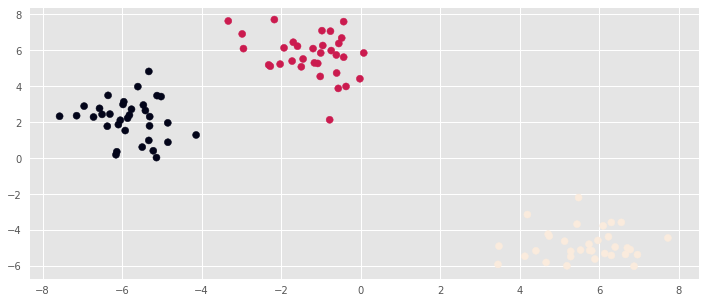

In [6]:
plt.scatter(X_toy[:,0], X_toy[:, 1], c=y_toy)

Проверьте Вашу имплементацию на простых данных (без этого пункта задание не считается выполненным).   
КОММЕНТАРИИ НЕ СТИРАТЬ!

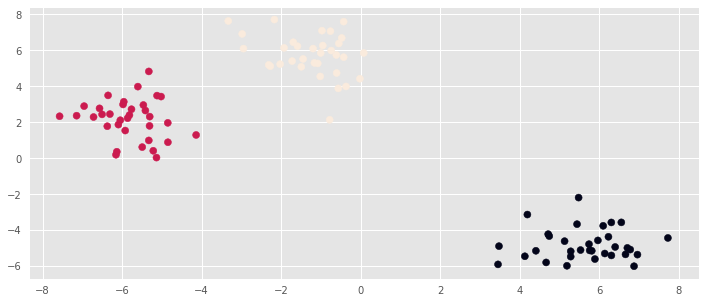

In [7]:
## Работоспособность KMeans
T_kmeans = Kmeans(k=3, epsilon=0.001)
T_kmeans.fit(X_toy)
plt.scatter(X_toy[:,0], X_toy[:, 1], c=T_kmeans.predict(X_toy))

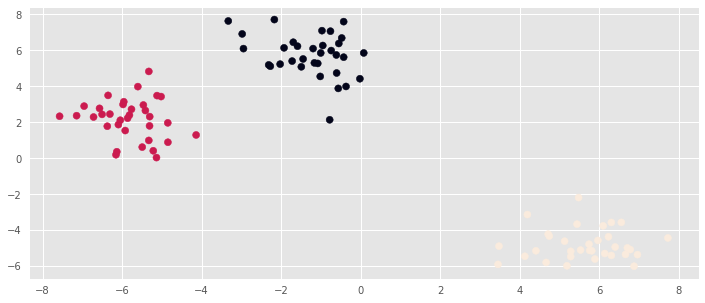

In [8]:
## Работоспособность KMeans++
T_kmeans_pl = Kmeans(k=3, init='k-means', epsilon=0.001)
T_kmeans_pl.fit(X_toy)
plt.scatter(X_toy[:,0], X_toy[:, 1], c=T_kmeans_pl.predict(X_toy))

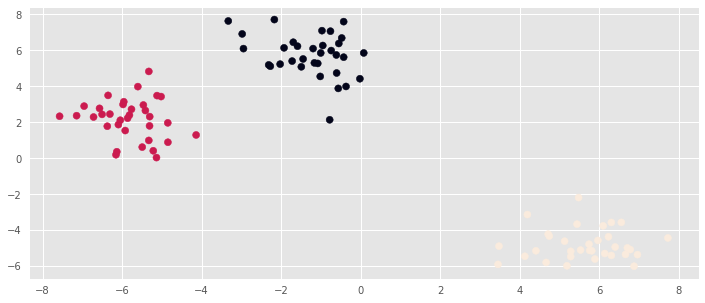

In [10]:
## Работоспособность KMeans с MiniBatchKMeans
T_minibatch = MiniBatchKMeans(batch_size=20, k=3, max_iter=100, epsilon=0.001)
T_minibatch.fit(X_toy)
plt.scatter(X_toy[:,0], X_toy[:, 1], c=T_minibatch.predict(X_toy))

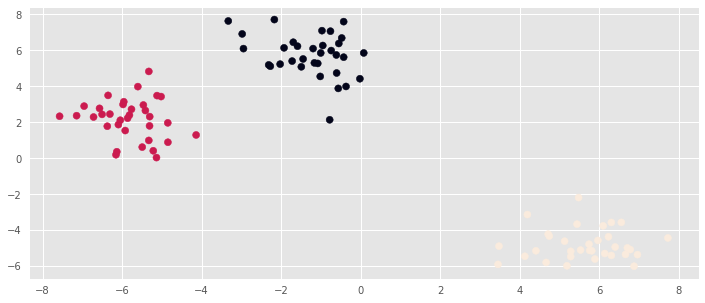

In [12]:
## Работоспособность KMeans++ с MiniBatchKMeans
T_minibatch_pl = MiniBatchKMeans(batch_size=30, k=3, init='k-means', max_iter=100, epsilon=0.001)
T_minibatch_pl.fit(X_toy)
plt.scatter(X_toy[:,0], X_toy[:, 1], c=T_minibatch_pl.predict(X_toy))

In [24]:
## Время выполнения алгоритма KMeans
a_kmeans = np.empty((0, ))
for i in xrange(100, 1000, 50):
    X, y = make_blobs(n_samples=i, n_features=2, centers=3, cluster_std=1, 
                      center_box=(-10.0, 10.0), shuffle=False, random_state=1234)
    result = %timeit -o -q -n 1 -r 1 T_kmeans.fit(X)
    a_kmeans = np.append(a_kmeans, result.best)

Coeff:  0.00216529834381


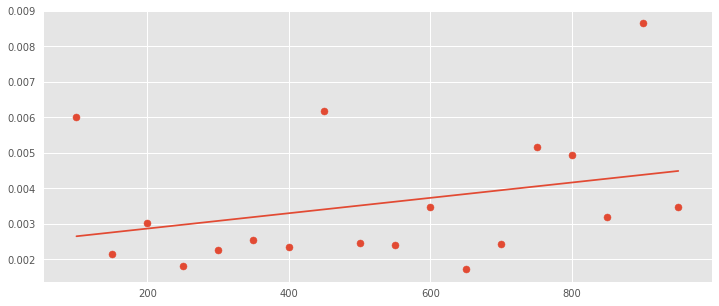

In [27]:
time_lab_kmeans = np.array([x for x in xrange(100, 1000, 50)])
m, b = np.polyfit(time_lab_kmeans, a_kmeans, 1)
plt.plot(time_lab_kmeans, m * time_lab_kmeans + b, '-')
plt.scatter([x for x in xrange(100, 1000, 50)], a_kmeans)
print 'Coeff: ', (m * time_lab_kmeans[0] + b - m * time_lab_kmeans[1] - b) / (time_lab_kmeans[0] - time_lab_kmeans[1]) * 1000

In [15]:
## Время выполнения алгоритма KMeans++
a_kmeansps = np.empty(0)
for i in xrange(100, 1000, 50):
    X, y = make_blobs(n_samples=i, n_features=2, centers=3, cluster_std=1, 
                      center_box=(-10.0, 10.0), shuffle=False, random_state=1234)
    result = %timeit -o -q -n 1 -r 1 T_kmeans_pl.fit(X)
    a_kmeansps = np.append(a_kmeansps, result.best)

Coeff:  0.00910373664124


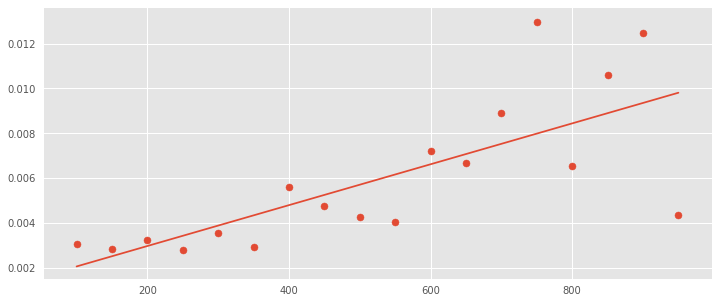

In [28]:
time_lab_kmeanspl = np.array([x for x in xrange(100, 1000, 50)])
m, b = np.polyfit(time_lab_kmeanspl, a_kmeansps, 1)
plt.plot(time_lab_kmeanspl, m * time_lab_kmeanspl + b, '-')
plt.scatter([x for x in xrange(100, 1000, 50)], a_kmeansps)
print 'Coeff: ', (m * time_lab_kmeanspl[0] + b - m * time_lab_kmeanspl[1] - b) / (time_lab_kmeanspl[0] - time_lab_kmeanspl[1]) * 1000

In [29]:
## Время выполнения алгоритма KMeans с MiniBatchKMeans
a_minib = np.empty(0)
for i in xrange(100, 1000, 50):
    X, y = make_blobs(n_samples=i, n_features=2, centers=3, cluster_std=1, 
                      center_box=(-10.0, 10.0), shuffle=False, random_state=1234)
    result = %timeit -o -q -n 1 -r 1 T_minibatch.fit(X)
    a_minib = np.append(a_minib, result.best)

Coeff:  0.0128176190167


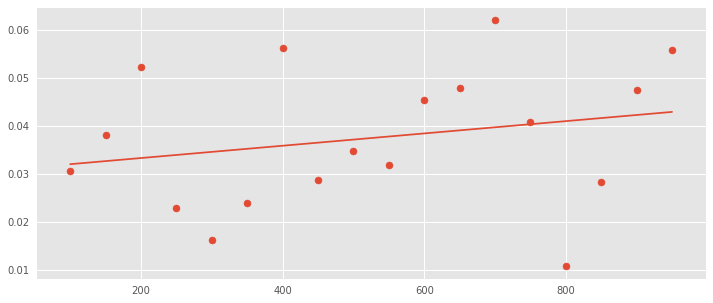

In [30]:
time_lab_minib = np.array([x for x in xrange(100, 1000, 50)])
m, b = np.polyfit(time_lab_minib, a_minib, 1)
plt.plot(time_lab_minib, m * time_lab_minib + b, '-')
plt.scatter([x for x in xrange(100, 1000, 50)], a_minib)
print 'Coeff: ', (m * time_lab_minib[0] + b - m * time_lab_minib[1] - b) / (time_lab_minib[0] - time_lab_minib[1]) * 1000

In [31]:
## Время выполнения алгоритма  KMeans++ с MiniBatchKMeans
a_minibpl = np.empty(0)
for i in xrange(100, 1000, 50):
    X, y = make_blobs(n_samples=i, n_features=2, centers=3, cluster_std=1, 
                      center_box=(-10.0, 10.0), shuffle=False, random_state=1234)
    result = %timeit -o -q -n 1 -r 1 T_minibatch_pl.fit(X)
    a_minibpl = np.append(a_minibpl, result.best)

Coeff:  0.0445309265971


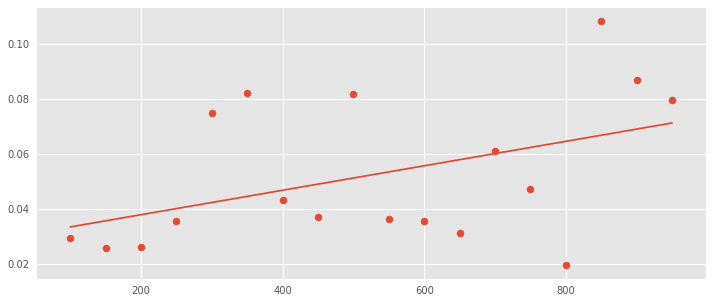

In [32]:
time_lab_minibpl = np.array([x for x in xrange(100, 1000, 50)])
m, b = np.polyfit(time_lab_minibpl, a_minibpl, 1)
plt.plot(time_lab_minibpl, m * time_lab_minibpl + b, '-')
plt.scatter([x for x in xrange(100, 1000, 50)], a_minibpl)
print 'Coeff: ', (m * time_lab_minibpl[0] + b - m * time_lab_minibpl[1] - b) / (time_lab_minibpl[0] - time_lab_minibpl[1]) * 1000

# Применение K-means на реальных данных

Загрузите [данные](https://github.com/brenden17/sklearnlab/blob/master/facebook/snsdata.csv) в которых содержится описание интересов профилей учеников старшей школы США.  (без этого пункта задание не считается выполненным).   
ВНИМАНИЕ! Проверка должна быть осуществлена на всех реализациях, иначе реализация не будет зачтена!

In [33]:
df_sns = pd.read_csv('snsdata.csv', sep=',')

Данные устроены так: 
* Год выпуска
* Пол
* Возраст
* Количество друзей
* 36 ключевых слов, которые встречаются в профилe facebook (интересы, сообщества, встречи)

* Удалите все признаки кроме 36 ключевых слов.
* Нормализуйте данные - из каждого столбца вычтите его среднее значение и поделите на стандартное отклонение.
* Используйте метод k-means чтобы выделить 9 кластеров
* Попробуйте проинтерпретировать каждый кластер проанализировав полученные центройды (Некоторые кластеры могут быть очень большие и очень маленькие - плохо интерпретируются)   
КОММЕНТАРИИ НЕ СТИРАТЬ!

In [34]:
df_sns.dropna(axis=0, inplace=True)
sns_val = df_sns.drop(['gradyear', 'gender', 'age', 'friends'], axis=1).values
sns_val_norm = (sns_val - sns_val.mean(axis=0)) / sns_val.std(axis=0)

In [35]:
## KMeans
sns_kmeans = Kmeans(k=9, max_iter=40)
sns_kmeans.fit(sns_val_norm)

Kmeans(epsilon=1e-05, init='random', k=9, max_iter=40, metric='euclidean',
    random_state=None)

In [36]:
df_sns['class'] = sns_kmeans.labels

In [37]:
df_sns[['class', 'gender', 'age']].groupby(['class', 'gender']).aggregate('count').transpose()

class     0        1           2           3         4        5         6      \
gender    F   M    F    M      F     M     F    M    F   M    F    M    F   M   
age     918  46  401  125  12091  3442  2394  237  143  50  591  117  798  54   

class      7         8      
gender     F    M    F   M  
age     1357  557  618  66

In [38]:
for i in range(0, 9):
    print i, (sns_kmeans.labels == i).sum()
F_kmeans = df_sns.drop(['gradyear', 'gender', 'age', 'friends', 'class'], axis=1)
F_kmeans = pd.DataFrame(columns=F_kmeans.columns, data=sns_kmeans.centroids).transpose()
for i in range(0, 9):
    print (F_kmeans.loc[:,i]).sort_values()[-5:]

0 964
1 526
2 15533
3 2631
4 193
5 708
6 852
7 1914
8 684
hair        0.416902
shopping    0.520816
cute        0.539069
dance       2.140717
dress       2.938782
Name: 0, dtype: float64
football    0.068471
rock        0.189671
music       0.519621
band        4.267668
marching    4.858686
Name: 1, dtype: float64
tennis   -0.095344
bible    -0.095083
drunk    -0.088513
soccer   -0.078096
blonde   -0.028431
Name: 2, dtype: float64
bible       0.607364
jesus       0.770662
god         0.778561
shopping    0.896302
church      1.049440
Name: 3, dtype: float64
football    0.169765
church      0.199119
soccer      0.245650
sports      0.314967
tennis      8.790526
Name: 4, dtype: float64
drunk     2.024811
sex       2.158345
hair      2.643869
drugs     3.037932
kissed    3.170894
Name: 5, dtype: float64
clothes    0.227600
mall       0.283317
cute       0.571457
sexy       2.346486
hot        3.019625
Name: 6, dtype: float64
sports        1.069254
softball      1.169072
football      1.28

In [39]:
## KMeans++
sns_kmeanspl = Kmeans(k=9, max_iter=4, init='k-means')
sns_kmeanspl.fit(sns_val_norm)

Kmeans(epsilon=1e-05, init='k-means', k=9, max_iter=4, metric='euclidean',
    random_state=None)

In [40]:
df_sns['class'] = sns_kmeanspl.labels

In [41]:
df_sns[['class', 'gender', 'age']].groupby(['class', 'gender']).aggregate('count').transpose()

class     0         1         2         3          4         5         6      \
gender    F   M     F    M    F   M     F    M     F    M    F   M     F   M   
age     980  86  1624  143  409  21  1152  542  2472  229  161  42  1178  99   

class       7          8      
gender      F     M    F   M  
age     10931  3434  404  98

In [42]:
for i in range(0, 9):
    print i, (sns_kmeanspl.labels == i).sum()
F_kmeanspl = df_sns.drop(['gradyear', 'gender', 'age', 'friends', 'class'], axis=1)
F_kmeanspl = pd.DataFrame(columns=F_kmeanspl.columns, data=sns_kmeanspl.centroids).transpose()
for i in range(0, 9):
    print (F_kmeanspl.loc[:,i]).sort_values()[-5:]

0 1066
1 1767
2 430
3 1694
4 2701
5 203
6 1277
7 14365
8 502
mall            0.501022
cheerleading    0.521922
shopping        0.867014
abercrombie     2.824202
hollister       3.204480
Name: 0, dtype: float64
hot             0.181978
church          0.240544
shopping        0.384546
cheerleading    0.431710
dance           2.176025
Name: 1, dtype: float64
clothes    1.552720
drugs      1.632205
hair       2.301933
kissed     2.766442
dress      4.287756
Name: 2, dtype: float64
music       0.479229
die         0.489642
football    1.090891
band        1.110908
death       1.462975
Name: 3, dtype: float64
hot         0.351856
mall        0.461318
shopping    0.502132
rock        0.853435
cute        1.293027
Name: 4, dtype: float64
rock         0.353871
hollister    0.416511
music        0.536391
band         4.885176
marching     7.840422
Name: 5, dtype: float64
drugs       0.935916
kissed      0.946456
hair        1.012835
sexy        1.526765
softball    2.042710
Name: 6, dtype: floa

In [43]:
## KMeans с MiniBatchKMeans
sns_minib = MiniBatchKMeans(batch_size=600, k=9, max_iter=60)
sns_minib.fit(sns_val_norm)

MiniBatchKMeans(batch_size=600, epsilon=0.0001, init='random', k=9,
        max_iter=60, metric='euclidean', random_state=None)

In [44]:
df_sns['class'] = sns_minib.labels

In [45]:
df_sns[['class', 'gender', 'age']].groupby(['class', 'gender']).aggregate('count').transpose()

class      0         1           2          3        4        5         6      \
gender     F   M     F    M      F     M    F   M    F   M    F   M     F   M   
age     1271  75  1497  487  11678  3131  593  28  265  68  442  99  1829  97   

class     7         8       
gender    F    M    F    M  
age     980  607  756  102

In [46]:
for i in range(0, 9):
    print i, (sns_minib.labels == i).sum()
F_minib = df_sns.drop(['gradyear', 'gender', 'age', 'friends', 'class'], axis=1)
F_minib = pd.DataFrame(columns=F_minib.columns, data=sns_minib.centroids).transpose()
for i in range(0, 9):
    print (F_minib.loc[:,i]).sort_values()[-5:]

0 1346
1 1984
2 14809
3 621
4 333
5 541
6 1926
7 1587
8 858
kissed      0.570721
shopping    0.845950
dress       0.857569
hair        0.995878
clothes     2.615405
Name: 0, dtype: float64
dance       0.076500
rock        0.608192
marching    0.991167
music       1.045690
band        1.205508
Name: 1, dtype: float64
drunk    -0.094311
bible    -0.087641
sexy     -0.065270
tennis   -0.040821
blonde   -0.027558
Name: 2, dtype: float64
shopping      0.401073
softball      0.470796
basketball    0.558374
church        1.673009
volleyball    4.058800
Name: 3, dtype: float64
death     0.405881
church    1.247712
god       3.469476
jesus     4.349445
bible     4.544499
Name: 4, dtype: float64
sports        0.113645
swimming      0.162452
basketball    0.210051
shopping      0.236296
soccer        5.035986
Name: 5, dtype: float64
cheerleading    0.872610
shopping        0.889675
hollister       1.082461
abercrombie     1.150620
mall            1.230979
Name: 6, dtype: float64
baseball      0.5

In [47]:
## KMeans++ с MiniBatchKMeans
sns_minibpl = MiniBatchKMeans(batch_size=600, k=9, max_iter=60, init='k-means')
sns_minibpl.fit(sns_val_norm)

MiniBatchKMeans(batch_size=600, epsilon=0.0001, init='k-means', k=9,
        max_iter=60, metric='euclidean', random_state=None)

In [48]:
df_sns['class'] = sns_minibpl.labels

In [49]:
df_sns[['class', 'gender', 'age']].groupby(['class', 'gender']).aggregate('count').transpose()

class    0         1         2        3          4         5         6       \
gender   F   M     F    M    F   M    F    M     F    M    F   M     F    M   
age     61  21  1925  150  331  33  626  310  2603  153  634  69  1079  139   

class       7          8       
gender      F     M    F    M  
age     11598  3709  454  110

In [50]:
for i in range(0, 9):
    print i, (sns_minibpl.labels == i).sum()
F_minibpl = df_sns.drop(['gradyear', 'gender', 'age', 'friends', 'class'], axis=1)
F_minibpl = pd.DataFrame(columns=F_minibpl.columns, data=sns_minibpl.centroids).transpose()
for i in range(0, 9):
    print (F_minibpl.loc[:,i]).sort_values()[-5:]

0 82
1 2075
2 364
3 936
4 2756
5 703
6 1218
7 15307
8 564
music      0.510743
church     1.286243
jesus      2.947370
god        3.472428
bible     13.450149
Name: 0, dtype: float64
shopping      0.340720
drunk         0.476640
dress         0.712168
volleyball    0.782247
dance         1.540735
Name: 1, dtype: float64
dress     2.500099
drugs     2.571993
hair      2.870199
sex       3.465580
kissed    4.643572
Name: 2, dtype: float64
music       0.219480
baseball    0.934607
football    0.963642
band        2.546547
marching    2.670859
Name: 3, dtype: float64
swimming    0.559578
mall        0.584106
rock        0.702579
shopping    0.705647
cute        1.382429
Name: 4, dtype: float64
clothes        0.591890
mall           0.625129
shopping       0.720731
abercrombie    3.894438
hollister      4.000078
Name: 5, dtype: float64
sports      0.913407
kissed      0.951270
drugs       1.053202
hair        1.243224
softball    2.020203
Name: 6, dtype: float64
baseball   -0.096162
soccer  

## Вывод
Чтобы проанализировать центроиды, я вывожу по 5 самых значимых признаков для каждого класса. В результате, можно заметить, что все модификации алгоритма kmeans уверенно выделяют следующие кластеры:
1. Интересующиеся модной одеждой (shopping, hollister, abercrombie)
2. Музыканты, музыкальные группы (band, marching, music, dance)
3. Верующие (god, church, jesus, bible)
4. Спортсмены  
    Обычно, выдяляются 2-3 группы со спортсменами различного рода (soccer, football, swimming, ...)
5. "Обычные" люди  
    Эта группа всегда самая многочисленная (~15000 человек) и характерезуется отсутствием явно выделяющихся признаков
6. Иногда проявляется кластер с "депресивыми" (die, death, drugs)
7. Оставшиеся кластеры сложно различить друг от друга
Я считаю, что выявить лидера не возможно, т.к. разбиение на кластеры происходит примерно одинакого, а также с учётом того, что от запуска к запуску результаты немного меняются явного фаворита нет. Однако, нужно учитывать, что модификации MiniBatchKmeans получают преимущество засчёт более высокой скорости работы.